# 1. Test Random Environment with OpenAI Gym

In [3]:
__credits__ = ["Desmond N.A. Hammond"]
%matplotlib widget

from os import path
from typing import Optional
import numpy as np

import gym
from gym import spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled
from numba import jit
from time import time
import numpy as np
from math import acos, pi
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interactive
from matplotlib import animation
import ipywidgets as widgets
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML, Javascript
from ipywidgets import IntSlider

        # # display animation and click play (the 6th button)
        # display(HTML(ani))
        # Javascript('document.querySelector(".anim-buttons > button:nth-child(6)").click()')


In [4]:
class PMSMEnv(gym.Env):

    metadata = {
        "render_modes": ["human", "console"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, parameters: Optional[dict] = None):
        #Initialize motor and all necessary parameters   
        if parameters is None:
            self.Rs = np.array(0.5) 
            self.Ld = np.array(3.5e-3)
            self.Lq = np.array(5e-3)
            self.p = np.array(3.)
            self.psi_f = np.array(0.33)
            self.Bm = np.array(0.0028)
            self.J = np.array(0.004)
            self.max_speed = np.array(500.)
            self.max_torque = np.array(10.)
            self.max_voltage = np.array(800.)
            self.max_current = np.array(500.)
            self.dt = np.array(0.001)
            self.simTime = np.array(1.)
        else:
            self.Rs = np.array(parameters.get("Rs")) if "Rs" in parameters else np.array(0.5) 
            self.Ld = np.array(parameters.get("Ld")) if "Ld" in parameters else np.array(3.5e-3)
            self.Lq = np.array(parameters.get("Lq")) if "Lq" in parameters else np.array(5e-3)
            self.p = np.array(parameters.get("p")) if "p" in parameters else np.array(3.)
            self.psi_f = np.array(parameters.get("psi_f")) if "psi_f" in parameters else np.array(0.33)
            self.Bm = np.array(parameters.get("Bm")) if "Bm" in parameters else np.array(0.0028)
            self.J = np.array(parameters.get("J")) if "J" in parameters else np.array(0.004)
            self.max_speed = np.array(parameters.get("max_speed")) if "max_speed" in parameters else np.array(500.)
            self.max_torque = np.array(parameters.get("max_torque")) if "max_torque" in parameters else np.array(10.)
            self.max_voltage = np.array(parameters.get("max_voltage")) if "max_voltage" in parameters else np.array(800.)
            self.max_current = np.array(parameters.get("max_current")) if "max_current" in parameters else np.array(500.)  
            self.dt = np.array(parameters.get("sample_time")) if "sample_time" in parameters else np.array(0.001)
            self.simTime = np.array(parameters.get("simulation_time")) if "simulation_time" in parameters else np.array(1.) 
            
        self.render_mode = render_mode

        min_action = np.array([-self.max_voltage, -self.max_voltage], dtype=np.float32)
        max_action = np.array([self.max_voltage, self.max_voltage], dtype=np.float32)

        min_observation = np.array([-self.max_current, -self.max_current, -self.max_speed, np.array(0.)], dtype=np.float32)
        max_observation = np.array([self.max_current, self.max_current, self.max_speed, 2*np.pi], dtype=np.float32)

        self.action_space = spaces.Box(low=min_action, high=max_action, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=min_observation, high=max_observation, shape=(4,), dtype=np.float32)

        # State variables
        self.state = None
        self.reset()
        
    
    def rungekutta4_step(self, diff_eqn, x0, dt):
        k1 = diff_eqn(x0)
        k2 = diff_eqn(x0 + k1 * dt/2.)
        k3 = diff_eqn(x0 + k2 * dt/2.)
        k4 = diff_eqn(x0 + k3 * dt)
        return x0 + (dt/6.) * (k1 + 2*k2 + 2*k3 + k4)
        
    def step(self, u, id_ref, iq_ref, omega_ref, theta_ref, T_load):
        self.id_ref = np.array(id_ref)
        self.iq_ref = np.array(iq_ref)
        self.omega_ref = np.array(omega_ref)
        self.theta_ref = np.array(theta_ref)

        self.T_load = np.clip(T_load, -self.max_torque, self.max_torque)
        self.vd, self.vq = np.clip(u, -self.max_voltage, self.max_voltage).tolist()
        self.x_prev = np.array([self.id,self.iq,self.omega,self.theta])
        
        # Compute new states
        self.id, self.iq, self.omega, self.theta = self.rungekutta4_step(diff_eqn=self.Xdot, x0=self.x_prev, dt=self.dt).tolist()
        self.x_current = np.array([self.id,self.iq,self.omega,self.theta])
        self.id_dot, self.iq_dot, self.omega_dot, self.theta_dot = self.Xdot(self.x_current).tolist()
        self.lambda_d = self.Ld*self.id + self.psi_f
        self.lambda_q = self.Lq*self.iq
        self.Te = (3/2)*(self.p)*(self.lambda_d*self.iq - self.lambda_q*self.id)
        
        # if self.render_mode == "human":
        #     self.render()
        
        # reduce time by one stimestep
        self.time_elapsed += self.dt

        # calculate error
        self.id_error = self.id - self.id_ref
        self.iq_error = self.iq - self.iq_ref
        self.omega_error = self.omega - self.omega_ref 
        self.theta_error = self.omega - self.theta_ref

        # calculate error
        self.reward = -np.abs(self.id_error) -np.abs(self.omega_error)

        # check if episode is done
        done = self.time_elapsed>=self.simTime
        self.time_elapsed = 0 if done else self.time_elapsed

        # set placeholder for info
        info = {}

        self.update_plot = True
        return self.get_observations(), self.reward, done, info


    def Xdot(self, xdot):
        id_, iq_, omega_, theta_= xdot.tolist()

        x_dot = np.array([self.vd/self.Ld - (self.Rs*id_)/self.Ld + (self.Lq*iq_*omega_*self.p)/self.Ld,
                         self.vq/self.Lq - (self.Rs*iq_)/self.Lq - (omega_*self.p*self.psi_f)/self.Lq - (self.Ld*id_*omega_*self.p)/self.Lq,
                         -(self.T_load + self.Bm*omega_ - (3*self.p*(iq_*(self.psi_f + self.Ld*id_) - self.Lq*id_*iq_))/2)/self.J,
                         omega_])
            
        id_dot, iq_dot, omega_dot, theta_dot = x_dot.tolist()
        
        return np.array([id_dot, iq_dot, omega_dot, theta_dot])


    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.state = None
        self.update_plot = False
        self.step_count = 0
        self.time_elapsed = 0
        self.dataset1 = np.zeros(shape=(int(self.simTime/self.dt),16))
        self.dataset2 = np.zeros(shape=(int(self.simTime/self.dt),16))
        # reset state variables
        if options is None:
            self.id_dot = np.array([0.])
            self.iq_dot = np.array([0.])
            self.omega_dot = np.array([0.])            
            self.theta_dot = np.array([0.])            
            self.id = np.array([0.])
            self.iq = np.array([0.])
            self.omega = np.array([0.])
            self.theta = np.array([0.])
        else:
            self.id = options.get("id_init") if "id_init" in options else np.array([0.])
            self.iq = options.get("iq_init") if "iq_init" in options else np.array([0.])
            self.omega = options.get("omega_init") if "omega_init" in options else np.array([0.])
            self.theta = options.get("theta_init") if "theta_init" in options else np.array([0.])
            self.id_dot = np.array([0.])
            self.iq_dot = np.array([0.])
            self.omega_dot = np.array([0.])
            self.theta_dot = np.array([0.])

        return self.get_observations(), {}

    def get_observations(self):
        if self.update_plot:
            # self.dataset1[self.step_count,:] = np.array([np.array(self.id), np.array(self.iq), np.array(self.omega), np.array(self.theta), np.array(self.id_dot), np.array(self.iq_dot),
            #                                    np.array(self.omega_dot), np.array(self.theta_dot), np.array(self.id_error), np.array(self.iq_error), np.array(self.omega_error), 
            #                                    np.array(self.vd), np.array(self.Te), np.array(self.lambda_d), np.array(self.reward), np.array(self.vq)], dtype=object)
            
            # self.dataset2[self.step_count,:] = np.array([self.id_ref, self.iq_ref, self.omega_ref, self.theta_ref, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 
            #                                 self.T_load, self.lambda_q, np.nan, np.nan], dtype=object).reshape(1,-1)
            self.dataset1[self.step_count,:] = np.random.rand(16)            
            self.dataset2[self.step_count,:] = np.random.rand(16)
                    # Manipulation 
            self.step_count += 1
            self.animate.value = "3"
        # sensor measurement noise can be implemented here
        observations = np.array([self.id, self.iq, self.omega], dtype=np.float32)
        return observations
   
    def render(self):

        #     if mode != 'console':
        #     raise NotImplementedError()
        # agent is represented as a cross, rest as a dot
        # create a figure and axes
        fig = plt.figure(figsize=(15,10))
        num_subplots = 16
        ax = [None]*num_subplots
        line1 = [None]*num_subplots
        line2 = [None]*num_subplots
        label1 = ['id', 'iq', 'omega', 'theta', 'id_dot', 'iq_dot', 'omega_dot', 'theta_dot', 'id_error', 'iq_error', 'omega_error', 'vd', 'T_elec', 'lambda_d', 'reward', 'vq']
        label2 = ['id_ref', 'iq_ref', 'omega_ref', 'theta_ref', '_', '_', '_', '_', '_', '_', '_', '_', 'T_load', 'lambda_q', '_', '_']
        t = np.linspace(0, self.simTime, int(self.simTime/self.dt))
        
        for i in range(num_subplots):
            # create axes
            ax[i] = plt.subplot(4,4,i+1, autoscale_on=True)
            ax[i].set_xlim(( 0, self.simTime) if i>=12 else False)          
            ax[i].set_ylim()
            ax[i].set_xlabel('Time') if i>=12 else ax[i].tick_params('x', labelbottom=False)
            # ax[i].set_ylabel('Magnitude')
            # ax[i].set_title('Phase Plane')
            ax[i].grid(True)# create objects that will change in the animation. These are initially empty, and will be given new values for each frame in the animation.
            line1[i], = ax[i].plot([], [], color='blue', lw=1, label=label1[i])     # ax.plot returns a list of 2D line objects
            line2[i], = ax[i].plot([], [], '-', color='red', lw=1, label=label2[i])
            ax[i].legend()


        def init():
            """initialize animation"""
            for i in range(num_subplots):
                line1[i].set_data([], [])
                line2[i].set_data([], [])
            return tuple(line1 + line2)

        def drawframe(n):
            # fig.clf()
            for i in range(num_subplots):
                self.dataset1 = np.random.rand(1000,16)            
                self.dataset2 = np.random.rand(1000,16)                
                line1[i].set_data(t, self.dataset1[:,i])
                line2[i].set_data(t, self.dataset2[:,i])
            # plt.draw()
            # plt.tight_layout()
            return tuple(line1 + line2)
            


        
        # plt.show()

        

        # choose the interval based on dt and the time to animate one step
        # t0 = time()
        # drawframe(0)
        # t1 = time()
        # interval = 1000*self.dt - (t1 - t0)
        # print(interval)

        self.animate = IntSlider(description='animate')
        self.animate.observe(drawframe, 'value')
        # display(x)

        # # Manipulation 
        # self.animate.value = "3"
        ani = animation.ArtistAnimation(fig, drawframe, interval=60, blit=True, repeat_delay=1000).save("movie.mp4")

        # ani = animation.FuncAnimation(fig, drawframe, frames=100, interval=interval, blit=True, init_func=init).to_jshtml(fps=40, default_mode='once')
        # # display animation and click play (the 6th button)
        # display(HTML(ani))
        # Javascript('document.querySelector(".anim-buttons > button:nth-child(6)").click()')
                
    def close(self):
        pass

In [ ]:
env = PMSMEnv(
    render_mode='human',
    parameters = {            
                    "Rs" : 0.5,
                    "Ld" : 3.5e-3,
                    "Lq" : 5e-3,
                    "p" : 3.,
                    "psi_f" : 0.33,
                    "Bm" : 0.0028,
                    "J" : 0.004,
                    "max_speed" : 500.,
                    "max_torque" : 10.,
                    "max_voltage" : 800.,
                    "max_current" : 500.,
                    "dt" : 0.001,
                    "simTime" : 1.
                }
)

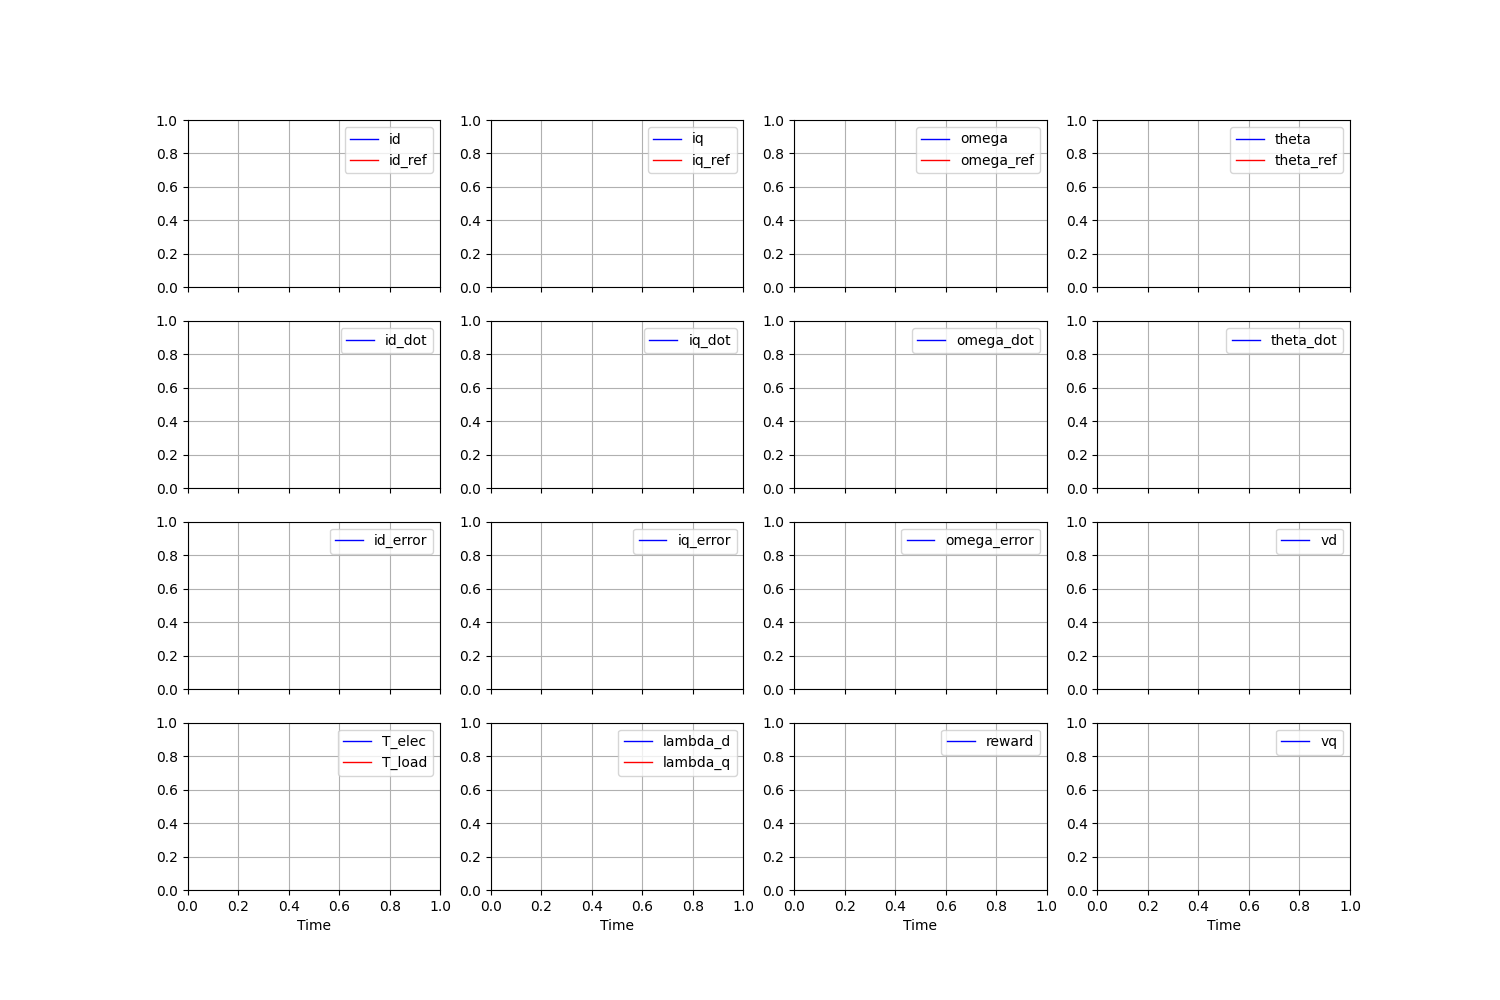

In [ ]:
env.render()

In [55]:
from ipywidgets import IntSlider
from IPython.display import display

x = IntSlider(description='x')
i=0
def update_y(args):
    global i
    i+=1
    print(i)

x.observe(update_y, 'value')
# display(x)

# Manipulation 
x.value = "3"

In [61]:
env.observation_space.sample()

array([-331.43753  ,  -52.955544 ,    4.4956603,    0.6649329],
      dtype=float32)

In [62]:
env.action_space.sample()

array([ 612.96124, -239.02986], dtype=float32)

In [63]:
# kp_i = 100;
# ki_i = 4000;

# fsat_d = 1e-3;
# fsat_q = 1e-3;


# kp_s = 1;
# ki_s = 3;

# %observer design
# Q = [1 0 0 0;
#      0 1 0 0;
#      0 0 100 0;
#      0 0 0 100;];

# R = diag([1 1]); %[1 0;0 1;];

# C = [1 0 0 0;
#     0 1 0 0;];

    
# P_init = 1e-3*eye(4)

In [64]:
episodes = 10
for episode in range(1, episodes+1):
    initial_conditions = {  "id_init": np.array([0.]),
                            "iq_init": np.array([3.]),                            
                            "omega_init": np.array([0.]),
                            "theta_init": np.array([0.])
                         }
    state = env.reset(options=initial_conditions)
    done = False
    score = 0 
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        id_ref = 0
        iq_ref = 0
        omega_ref = 2
        theta_ref = 2
        T_load = 0

        n_state, reward, done, info = env.step(action, id_ref, iq_ref, omega_ref, theta_ref, T_load)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:[-401886.12275807]
Episode:2 Score:[-399595.28946565]
Episode:3 Score:[-351815.63500374]
Episode:4 Score:[-358753.68510311]
Episode:5 Score:[-405122.48296609]
Episode:6 Score:[-412017.1881578]
Episode:7 Score:[-398582.27782201]
Episode:8 Score:[-352589.48186172]
Episode:9 Score:[-361671.76781791]
Episode:10 Score:[-383426.5889637]


<IPython.core.display.Javascript object>

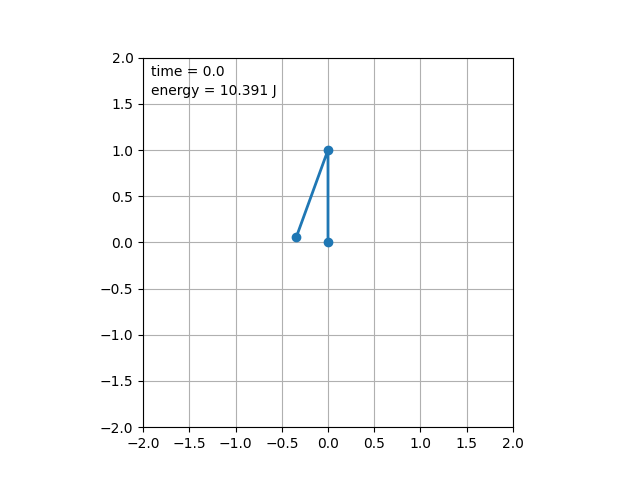

In [3]:
"""
General Numerical Solver for the 1D Time-Dependent Schrodinger's equation.

adapted from code at http://matplotlib.sourceforge.net/examples/animation/double_pendulum_animated.py

Double pendulum formula translated from the C code at
http://www.physics.usyd.edu.au/~wheat/dpend_html/solve_dpend.c

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML, Javascript

class DoublePendulum:
    """Double Pendulum Class

    init_state is [theta1, omega1, theta2, omega2] in degrees,
    where theta1, omega1 is the angular position and velocity of the first
    pendulum arm, and theta2, omega2 is that of the second pendulum arm
    """
    def __init__(self,
                 init_state = [120, 0, -20, 0],
                 L1=1.0,  # length of pendulum 1 in m
                 L2=1.0,  # length of pendulum 2 in m
                 M1=1.0,  # mass of pendulum 1 in kg
                 M2=1.0,  # mass of pendulum 2 in kg
                 G=9.8,  # acceleration due to gravity, in m/s^2
                 origin=(0, 0)): 
        self.init_state = np.asarray(init_state, dtype='float')
        self.params = (L1, L2, M1, M2, G)
        self.origin = origin
        self.time_elapsed = 0

        self.state = self.init_state * np.pi / 180.
    
    def position(self):
        """compute the current x,y positions of the pendulum arms"""
        (L1, L2, M1, M2, G) = self.params

        x = np.cumsum([self.origin[0],
                       L1 * sin(self.state[0]),
                       L2 * sin(self.state[2])])
        y = np.cumsum([self.origin[1],
                       -L1 * cos(self.state[0]),
                       -L2 * cos(self.state[2])])
        return (x, y)

    def energy(self):
        """compute the energy of the current state"""
        (L1, L2, M1, M2, G) = self.params

        x = np.cumsum([L1 * sin(self.state[0]),
                       L2 * sin(self.state[2])])
        y = np.cumsum([-L1 * cos(self.state[0]),
                       -L2 * cos(self.state[2])])
        vx = np.cumsum([L1 * self.state[1] * cos(self.state[0]),
                        L2 * self.state[3] * cos(self.state[2])])
        vy = np.cumsum([L1 * self.state[1] * sin(self.state[0]),
                        L2 * self.state[3] * sin(self.state[2])])

        U = G * (M1 * y[0] + M2 * y[1])
        K = 0.5 * (M1 * np.dot(vx, vx) + M2 * np.dot(vy, vy))

        return U + K

    def dstate_dt(self, state, t):
        """compute the derivative of the given state"""
        (M1, M2, L1, L2, G) = self.params

        dydx = np.zeros_like(state)
        dydx[0] = state[1]
        dydx[2] = state[3]

        cos_delta = cos(state[2] - state[0])
        sin_delta = sin(state[2] - state[0])

        den1 = (M1 + M2) * L1 - M2 * L1 * cos_delta * cos_delta
        dydx[1] = (M2 * L1 * state[1] * state[1] * sin_delta * cos_delta
                   + M2 * G * sin(state[2]) * cos_delta
                   + M2 * L2 * state[3] * state[3] * sin_delta
                   - (M1 + M2) * G * sin(state[0])) / den1

        den2 = (L2 / L1) * den1
        dydx[3] = (-M2 * L2 * state[3] * state[3] * sin_delta * cos_delta
                   + (M1 + M2) * G * sin(state[0]) * cos_delta
                   - (M1 + M2) * L1 * state[1] * state[1] * sin_delta
                   - (M1 + M2) * G * sin(state[2])) / den2
        
        return dydx

    def step(self, dt):
        """execute one time step of length dt and update state"""
        self.state = integrate.odeint(self.dstate_dt, self.state, [0, dt])[1]
        self.time_elapsed += dt

#------------------------------------------------------------
# set up initial state and global variables
pendulum = DoublePendulum([180., 0.0, -20., 0.0])
dt = 1./30 # 30 fps

#------------------------------------------------------------
# set up figure and animation
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=True,
                     xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    time_text.set_text('')
    energy_text.set_text('')
    return line, time_text, energy_text

def animate(i):
    """perform animation step"""
    global pendulum, dt
    # pendulum.step(dt)
    line.set_data(*pendulum.position())
    time_text.set_text('time = %.1f' % pendulum.time_elapsed)
    energy_text.set_text('energy = %.3f J' % pendulum.energy())
    return line, time_text, energy_text

# choose the interval based on dt and the time to animate one step
from time import time
t0 = time()
animate(0)
t1 = time()
interval = 1000 * dt - (t1 - t0)

ani = animation.FuncAnimation(fig, animate, frames=100, interval=interval, blit=True, init_func=init).to_jshtml(fps=40, default_mode='once')
# display animation and click play (the 6th button)
display(HTML(ani))
Javascript('document.querySelector(".anim-buttons > button:nth-child(6)").click()')

In [263]:
for _ in range(200):
    pendulum.step(dt)


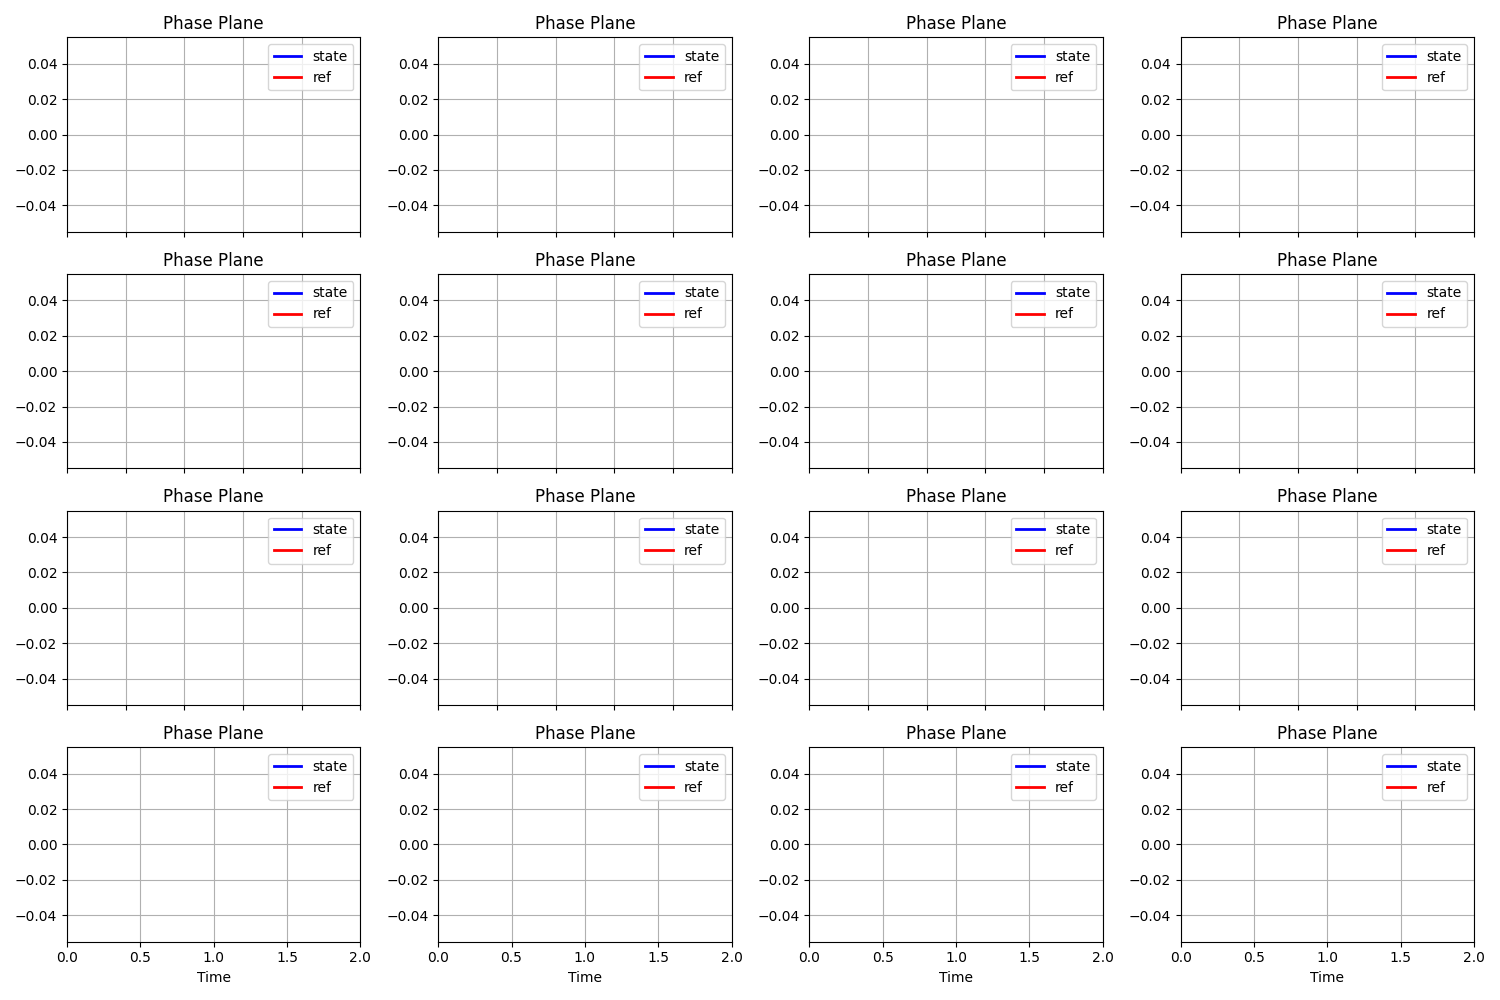

In [49]:
%matplotlib widget

import numpy as np
from math import acos, pi
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interactive
from matplotlib import animation
import ipywidgets as widgets

# create a figure and axes
fig = plt.figure(figsize=(15,10))
num_subplots = 16
ax = [None]*num_subplots
line1 = [None]*num_subplots
line2 = [None]*num_subplots


for i in range(num_subplots):
    # create axes
    ax[i] = plt.subplot(4,4,i+1)
    ax[i].set_xlim(( 0, 2) if i>=12 else False)          
    # ax[i].set_ylim((-2, 2))
    ax[i].set_xlabel('Time') if i>=12 else ax[i].tick_params('x', labelbottom=False)
    # ax[i].set_ylabel('Magnitude')
    ax[i].set_title('Phase Plane')
    ax[i].grid(True)# create objects that will change in the animation. These are initially empty, and will be given new values for each frame in the animation.
    line1[i], = ax[i].plot([], [], color='blue', lw=2, label='state')     # ax.plot returns a list of 2D line objects
    line2[i], = ax[i].plot([], [], '-', color='red', lw=2, label='ref')
    ax[i].legend()

plt.tight_layout()

def init():
    """initialize animation"""
    for i in range(num_subplots):
        line1[i].set_data([], [])
        line2[i].set_data([], [])
    return tuple(line1 + line2)

def animate(i):
    """perform animation step"""
    global pendulum, dt
    pendulum.step(dt)
    
    line.set_data(*pendulum.position())

    return line, time_text, energy_text


In [22]:
# animation function. This is called sequentially
def drawframe(n):
    for i in range(num_subplots):
        x = np.linspace(0, 2, 1000)
        y1 = np.sin(2 * np.pi * (x - 0.01 * n))
        y2 = np.cos(2 * np.pi * (x - 0.01 * n))
        line1[i].set_data(x, y1)
        line2[i].set_data(x, y2)
        # txt_title.set_text('Frame = {0:4d}'.format(n))
    return tuple(line1 + line2)


# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=1, interval=1, init_func=init, blit=True)
anim
plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def f(t):
    s1 = np.cos(2*np.pi*t)
    e1 = np.exp(-t)
    return s1 * e1

t1 = np.arange(0.0, 5.0, 0.1)
t2 = np.arange(0.0, 5.0, 0.02)
t3 = np.arange(0.0, 2.0, 0.01)


fig, axs = plt.subplots(2, 1, constrained_layout=True)
axs[0].plot(t1, f(t1), 'o', t2, f(t2), '-')
axs[0].set_title('subplot 1')
axs[0].set_xlabel('distance (m)')
axs[0].set_ylabel('Damped oscillation')
fig.suptitle('This is a somewhat long figure title', fontsize=16)

axs[1].plot(t3, np.cos(2*np.pi*t3), '--')
axs[1].set_xlabel('time (s)')
axs[1].set_title('subplot 2')
axs[1].set_ylabel('Undamped')

plt.show()


Make plots appear as a pop up window, chose the backend: 'gtk', 'inline', 'osx', 'qt', 'qt4', 'tk', 'wx'

# 2. Create a Deep Learning Model with Keras

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
actions

In [ ]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
del model 

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

# 3. Build Agent with Keras-RL

In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

In [ ]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

In [ ]:
_ = dqn.test(env, nb_episodes=15, visualize=True)

# 4. Reloading Agent from Memory

In [ ]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
del model
del dqn
del env

In [ ]:
env = gym.make('CartPole-v0')
actions = env.action_space.n
states = env.observation_space.shape[0]
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('dqn_weights.h5f')

In [ ]:
_ = dqn.test(env, nb_episodes=5, visualize=True)

In [ ]:

# state matrix
a = g/(lp*(4.0/3 - mp/(mp+mk)))
A = np.array([[0, 1, 0, 0],
              [0, 0, a, 0],
              [0, 0, 0, 1],
              [0, 0, a, 0]])

# input matrix
b = -1/(lp*(4.0/3 - mp/(mp+mk)))
B = np.array([[0], [1/mt], [0], [b]])

In [ ]:

R = np.eye(2, dtype=int)          # choose R (weight for input)
Q = 5*np.eye(4, dtype=int)        # choose Q (weight for state)

# get riccati solver
from scipy import linalg

# solve ricatti equation
P = linalg.solve_continuous_are(A, B, Q, R)

# calculate optimal controller gain
K = np.dot(np.linalg.inv(R),
           np.dot(B.T, P))

In [ ]:
def apply_state_controller(K, x):
    # feedback controller
    u = -np.dot(K, x)   # u = -Kx
    if u > 0:
        return 1, u     # if force_dem > 0 -> move cart right
    else:
        return 0, u     # if force_dem <= 0 -> move cart left

In [ ]:

# get environment
env = gym.make('CartPole-v0')
env.env.seed(1)     # seed for reproducibility
obs = env.reset()

for i in range(1000):
    env.render()
    
    # get force direction (action) and force value (force)
    action, force = apply_state_controller(K, obs)
    
    # absolute value, since 'action' determines the sign, F_min = -10N, F_max = 10N
    abs_force = abs(float(np.clip(force, -10, 10)))
    
    # change magnitute of the applied force in CartPole
    env.env.force_mag = abs_force

    # apply action
    obs, reward, done, _ = env.step(action)
    if done:
        print(f'Terminated after {i+1} iterations.')
        break

env.close()